In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
model_dir = '/kuacc/users/mali18/dicomogan/logs/_9132_seq_modulation_gaugan22022-10-24T00-36-21'
img_root = '/kuacc/users/abond19/datasets/aligned_fashion_dataset'
inverted_img_root =  '/kuacc/users/abond19/datasets/inverted_fashion_dataset'
inversion_root =  '/kuacc/users/abond19/datasets/w+_fashion_dataset/fashion/PTI/'

In [3]:
device = 'cuda'

In [4]:
videos = [
'2c108787',
'8c112803',
'2c108113',
]

In [5]:
from experiments_utils import *
model = load_model_from_dir(model_dir).to(device)

Using /scratch/users/mali18/.cache/torch_extensions/py37_cu113 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /scratch/users/mali18/.cache/torch_extensions/py37_cu113/fused/build.ninja...
Building extension module fused...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module fused...
Loading custom kernel...
Using /scratch/users/mali18/.cache/torch_extensions/py37_cu113 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /scratch/users/mali18/.cache/torch_extensions/py37_cu113/upfirdn2d/build.ninja...
Building extension module upfirdn2d...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module upfirdn2d...
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
Restored

In [6]:
def save_gif(video, save_path):
    # Assuming that the current shape is T x C x H x W
    video = (video * 255).astype(np.uint8)
    import imageio
    with imageio.get_writer(f'{save_path}.gif', mode='I') as writer:
        for img in video:
            writer.append_data(img)

In [13]:
# load images
import os
import torch 
from PIL import Image
import torchvision.transforms as transforms
IMG_EXTENSIONS = ['.png', '.PNG']
TXT_EXTENSIONS = ['.txt']

crop = None
size = (256, 192)
trans_list = []
if crop is not None:
    trans_list.append(transforms.CenterCrop(tuple(crop)))
if size is not None:
    trans_list.append(transforms.Resize(tuple(size)))
trans_list.append(transforms.ToTensor())
img_transform=transforms.Compose(trans_list)

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def is_text_file(filename):
    return any(filename.endswith(extension) for extension in TXT_EXTENSIONS)

def get_image(img_path):
    img = Image.open(img_path).convert('RGB')
    return img

def get_inversion(inversion_path):
    w_vector = torch.load(inversion_path, map_location='cpu')
    assert (w_vector.shape == (1, 18, 512)), "Inverted vector has incorrect shape"
    return w_vector

def load_video(vid_path):
    images, inversions, sampleT, inversion_imgs = [], [], [], [] 
    fname = vid_path
    for f in sorted(os.listdir(os.path.join(img_root, fname)))[5:20]:
        if is_image_file(f):
            imname = f[:-4]
            images.append(img_transform(get_image(os.path.join(img_root, fname, f))))
            inversion_imgs.append(img_transform(get_image(os.path.join(inverted_img_root, fname, f))))
            inversions.append(get_inversion(os.path.join(os.path.join(inversion_root, fname, imname + ".pt"))))
            sampleT.append(int(imname))
    
    return torch.stack(images).to(device), torch.cat(inversions, 0).to(device), torch.Tensor(sampleT).to(device), torch.stack(inversion_imgs).to(device)

In [11]:
def forward(self, videos, inversions, sampleT, input_desc, flag='F'):
        """
        return a dictionary of tensors in the range [-1, 1]
        """
        vid = videos # B x T x ch x H x W -- range [0, 1]
        input_desc = input_desc 
        sampleT = sampleT 
        
        bs, T, ch, height, width = vid.size()
        n_frames = T
        ts = (sampleT) / model.video_length
        ts = ts - ts[0] 


        video_sample = vid # B x T x C x H x W 
        video_sample = video_sample.permute(1,0,2,3,4) # T x B x C x H x W 
        video_sample = video_sample.contiguous().view(n_frames * bs, ch, height, width) # T*B x C x H x W 
        video_sample_norm = video_sample * 2 - 1 # range [-1, 1] to pass to the generator and disc

        # inversions reshape
        inversions_bf = inversions # B, T x n_layers x D
        bs, T, n_channels, dim = inversions_bf.shape
        inversions_tf = inversions_bf.permute(1, 0, 2, 3)
        inversions = inversions_tf.contiguous().reshape(T * bs, n_channels, dim) # T * B x n_layers x D

        # downsample res for vae
        vid_rs_full = nn.functional.interpolate(video_sample, scale_factor=0.5, mode="bicubic", align_corners=False, recompute_scale_factor=True)
        vid_rs = vid_rs_full.view(n_frames, bs, ch, int(height*0.5),int(width*0.5) )
        vid_rs = vid_rs.permute(1,0,2,3,4) #  B x T x C x H//2 x W//2

        # encode text
        txt_feat = self.clip_encode_text(input_desc)  # B x D
        txt_feat = txt_feat.unsqueeze(0).repeat(n_frames,1,1)
        txt_feat = txt_feat.view(bs * n_frames, -1)  # T*B x D

        # vae encode frames
        zs, zd, mu_logvar_s, mu_logvar_d = self.bVAE_enc(vid_rs, ts)
        z_vid = torch.cat((zs, zd), 1) # T*B x D 
        video_style = zs[:, :self.vae_cond_dim]
        video_content = zs[:, self.vae_cond_dim:]
        video_dynamics = zd

        muT, logvarT = self.text_enc(txt_feat)
        zT = self.reparametrize(muT, logvarT) # T*B x D 
        text_video_style = zT
        
        
        frame_rep = (txt_feat, video_content, video_dynamics) # T*B x D1+D2
#         print(video_dynamics.shape)

        # predict latents delta
        if flag == 'F':
            src_inversion = inversions_tf[0:1]
        elif flag == 'L':
            src_inversion = inversions_tf[-1:]
        elif flag == 'M':
            src_inversion = inversions_tf.mean(0, keepdims=True) # 1 x B x 18 x 512
            
        src_inversion_tf = src_inversion.repeat(T, 1, 1, 1)
#         src_inversion_tf = torch.cat([inversions_tf[:, :, :4, :], src_inversion_tf[:, :, 4:, :]], -2)
        src_inversion = src_inversion_tf.reshape(T*bs, n_channels, dim)
        w_latents = src_inversion + self.delta_inversion_weight * self.style_mapper(src_inversion, *frame_rep)
        
        ret = self.stylegan_G(w_latents) / 2 + 0.5 
        ret = ret.reshape(T, bs, ret.shape[1], ret.shape[2], ret.shape[3]).permute(1, 0, 2, 3, 4)
        return torch.clamp(ret, 0, 1)

# Reconstruct Video

In [14]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import torch.nn as nn
with torch.no_grad():
    for video in tqdm(videos):
        images, inversions, sampleT, inversion_imgs = load_video(video)
        save_dir = os.path.join('applications_results', f"{model_dir.split('/')[-1]}", video)
        os.makedirs(save_dir, exist_ok=True)
        # org
        save_gif(images.permute(0, 2, 3, 1).detach().cpu().numpy(), f'{save_dir}/original')
        
        # inversion
        save_gif(inversion_imgs.permute(0, 2, 3, 1).detach().cpu().numpy(), f'{save_dir}/inversion')
        
        tgt_desc = "tshirt with a very short sleeves"
#         src_desc = "a photo of a woman wearing white t-shirt"
        txt_feat = model.clip_encode_text([tgt_desc]) # - model.clip_encode_text([src_desc])
        edited_videos = model(images.unsqueeze(0), 
                              sampleT,
                              inversions.mean(0, keepdims=True),
                              txt_feat)[0]
        save_gif(edited_videos.permute(0, 2, 3, 1).detach().cpu().numpy(), f'{save_dir}/Mean_Frame')
        to_PIL(model.stylegan_G(inversions.mean(0, keepdims=True))[0]).save(f'{save_dir}/mean_frame.png')
        
        
        edited_videos = model(images.unsqueeze(0), 
                              sampleT,
                              inversions[-1:],
                              txt_feat)[0]
        save_gif(edited_videos.permute(0, 2, 3, 1).detach().cpu().numpy(), f'{save_dir}/Last_Frame')
        to_PIL(model.stylegan_G(inversions[-1:])[0]).save(f'{save_dir}/last_frame.png')
        
        edited_videos = model(images.unsqueeze(0), 
                              sampleT,
                              inversions[0:1],
                              txt_feat)[0]
        save_gif(edited_videos.permute(0, 2, 3, 1).detach().cpu().numpy(), f'{save_dir}/First_Frame')
        to_PIL(model.stylegan_G(inversions[0:1])[0]).save(f'{save_dir}/first_frame.png')
        
        
        edited_videos = model(images.unsqueeze(0), 
                              sampleT,
                              inversions[5:6],
                              txt_feat)[0]
        save_gif(edited_videos.permute(0, 2, 3, 1).detach().cpu().numpy(), f'{save_dir}/Middle_Frame')
        to_PIL(model.stylegan_G(inversions[5:6])[0]).save(f'{save_dir}/middle_frame.png')
#         edited_videos = forward(model, images.unsqueeze(0), inversions.unsqueeze(0), sampleT, [des], flag='L')[0]
#         save_gif(edited_videos.permute(0, 2, 3, 1).detach().cpu().numpy(), f'{save_dir}/Last_frame')

#         edited_videos = forward(model, images.unsqueeze(0), inversions.unsqueeze(0), sampleT, [des], flag='F')[0]
#         save_gif(edited_videos.permute(0, 2, 3, 1).detach().cpu().numpy(), f'{save_dir}/First_frame')

        
        

100%|██████████| 3/3 [00:40<00:00, 13.65s/it]


In [15]:
videos = [
'2c112948',
'8c109258',
'8c110569'
]

In [ ]:
tgt_desc = [
    "A picture of a woman wearing a Women's pink t-shirt with v-neckline and short sleeves and blue skirt", 
    "A picture of a woman wearing a Women's black sleeveless t-shirt with v-neckline and blue jeans"
    
#     'Blue T-shirts Made from rayon-nylon blend Round neckline Slogan printed front Pearl detail Short sleeves Regular fit',
#     'Dresses Shift White One shoulder design Made from cotton Lace detailed ruffled yoke Regular fit Mini length Sleeveless',
#     'Multi Leggings Made from poly-lycra blend Elasticated waistband All over crane print Tape detail at sides Bodycon fit',
#     'a short white Sleeveless Dresses made from cotton',
]

In [ ]:
# swape the dynamics
from tqdm import tqdm
with torch.no_grad():
    for j, des in enumerate(tgt_desc):
        a_images, a_inv, a_sampleT = [], [], []
        for video in tqdm(videos):
            images, inversions, sampleT, inversion_imgs = load_video(video)
            save_dir = os.path.join('results', f"{model_dir.split('/')[-1]}_content_swapped", video)
            os.makedirs(save_dir, exist_ok=True)
            # org
#             save_gif(images.permute(0, 2, 3, 1).detach().cpu().numpy(), f'{save_dir}/original')

            # inversion
#             save_gif(inversion_imgs.permute(0, 2, 3, 1).detach().cpu().numpy(), f'{save_dir}/inversion')
            
            a_images.append(images)
            a_inv.append(inversions)
            a_sampleT.append(sampleT)

        

#         images = images.unsqueeze(0).repeat(ln_desc, 1, 1, 1, 1)
#         inversions = inversions.unsqueeze(0).repeat(ln_desc, 1, 1, 1)
        edited_videos = forward_triple(model, torch.stack(a_images), torch.stack(a_inv), sampleT, [des] * len(videos))
        
        for edited_video, video in zip(edited_videos, videos):
            save_dir = os.path.join('results', f"{model_dir.split('/')[-1]}_content_swapped", video)
            save_gif(edited_video.permute(0, 2, 3, 1).detach().cpu().numpy(), f'{save_dir}/desc_{j}')
        

In [75]:
images, inversions, sampleT, inversion_imgs = load_video('8c113974')

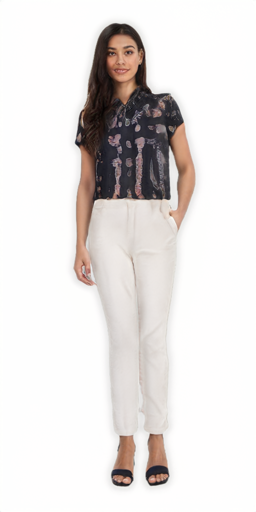

In [90]:
T = np.random.choice(len(sampleT), 6)
mean_inv = inversions[T].mean(0, keepdims=True)

with torch.no_grad():
    mean = model.stylegan_G(mean_inv)[0]
display(to_PIL(mean).resize((128*2, 256*2)))

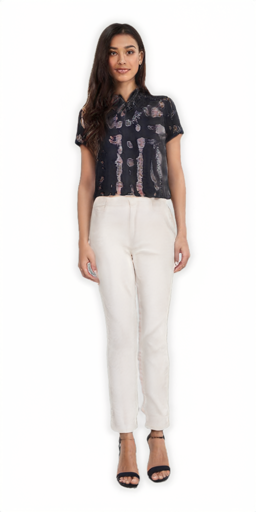

In [91]:
T = np.random.choice(len(sampleT), 6)
mean_inv = inversions[T].mean(0, keepdims=True)

with torch.no_grad():
    mean = model.stylegan_G(mean_inv)[0]
display(to_PIL(mean).resize((128*2, 256*2)))

In [72]:
# des = tgt_desc[-1]
# with torch.no_grad():
#     ws, edited_videos = forward(model, images.unsqueeze(0), inversions.unsqueeze(0), sampleT, [des])


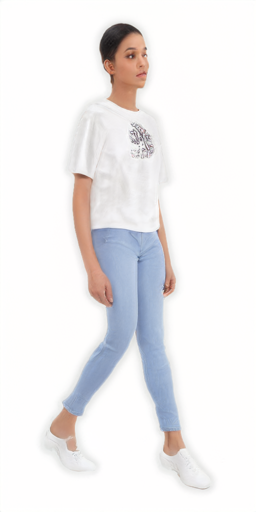

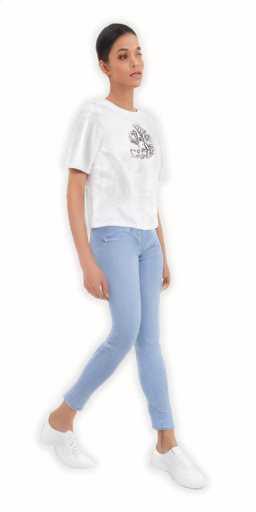

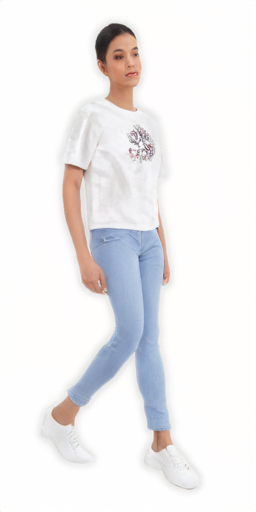

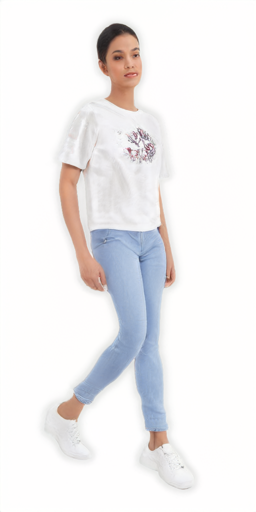

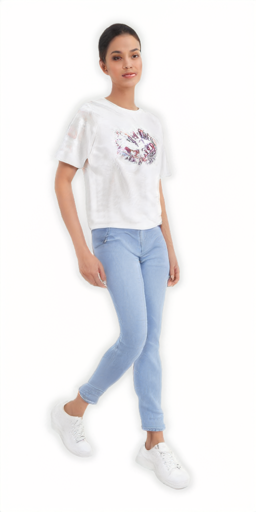

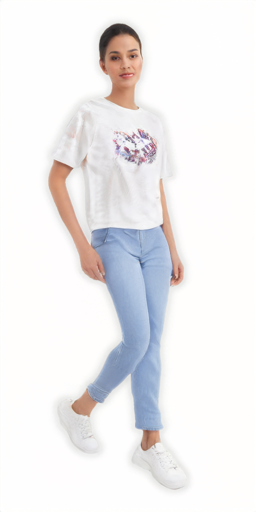

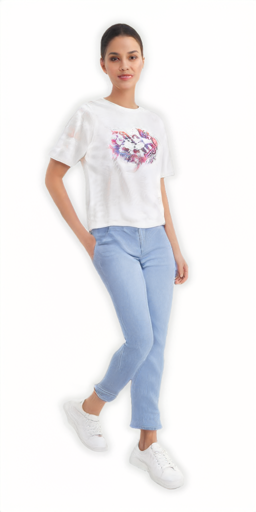

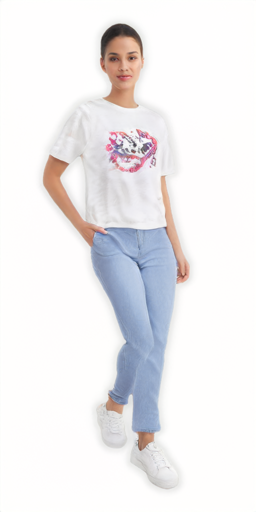

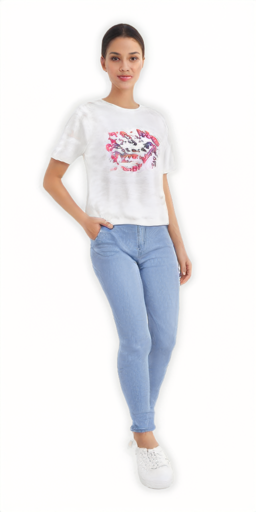

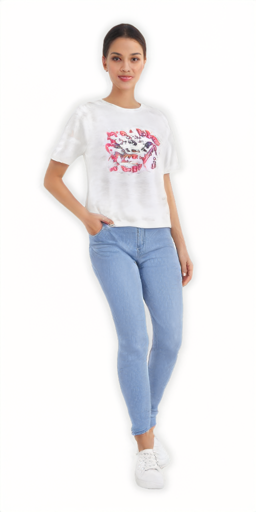

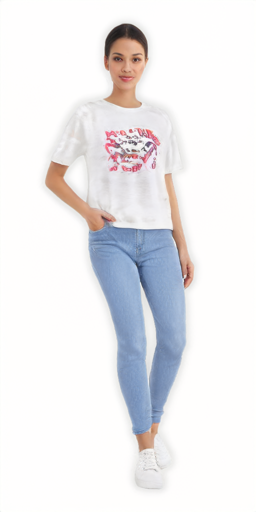

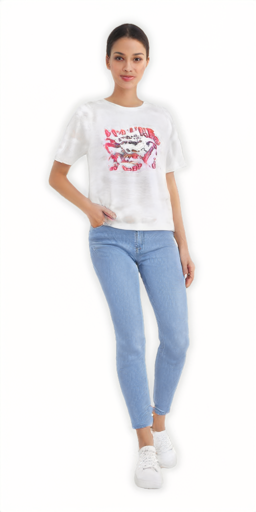

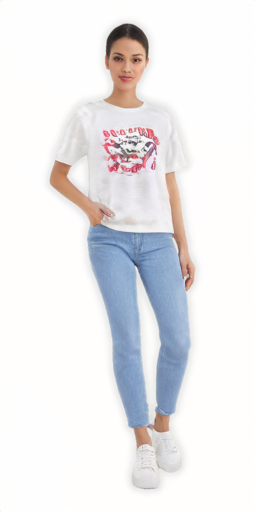

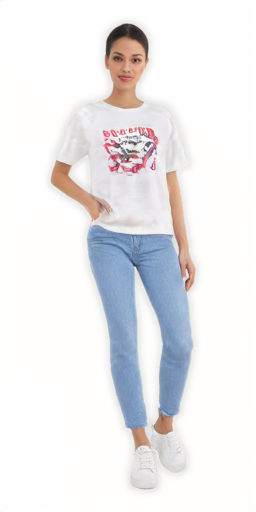

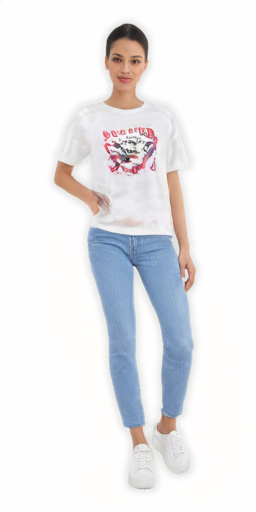

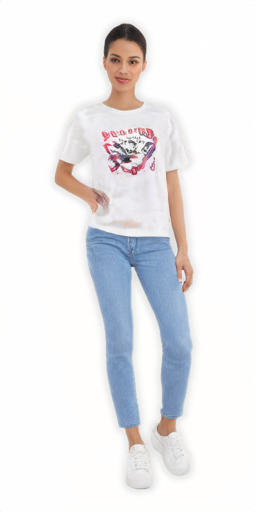

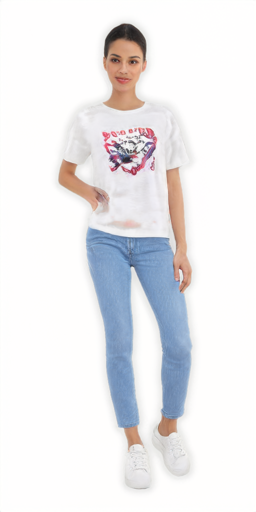

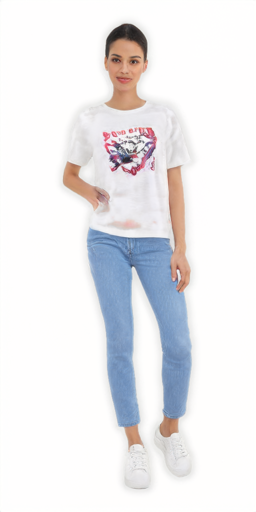

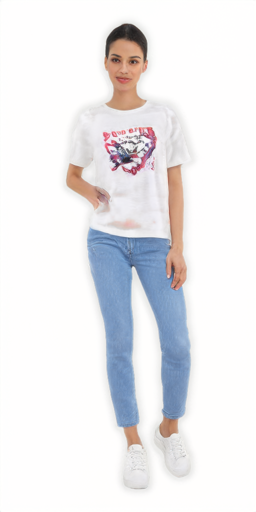

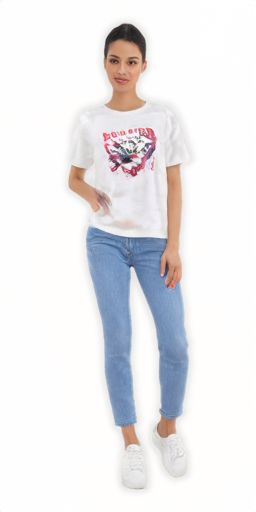

In [73]:
for i in range(20):
    a_inv = inversions[i:i+1]
    with torch.no_grad():
        a = model.stylegan_G(a_inv)[0]
    display(to_PIL(a).resize((128*2, 256*2)))

In [34]:
b_inv = ws[15:16]
with torch.no_grad():
    b = model.stylegan_G(b_inv)[0]
to_PIL(b).resize((128*2, 256*2))

NameError: name 'ws' is not defined

In [167]:
# des = tgt_desc[-1]
# with torch.no_grad():
#     ws, edited_videos = forward_triple(model, images.unsqueeze(0), inversions.unsqueeze(0), sampleT, [des])


In [168]:
import torch.nn as nn
l2_latent_loss = nn.MSELoss()

In [178]:
l2_latent_loss(a_inv[0, l:r], b_inv[0,l:r])

tensor(0.0015, device='cuda:0')

In [170]:
diff = a_inv[0, 6:8] - b_inv[0, 6:8]
diff.abs().sum(-1)

tensor([26.6970, 19.9226], device='cuda:0')

In [218]:
l, r = 0, 2
tgt_w = a_inv.clone()
tgt_w[0, l:r] = b_inv[0][l:r]
# tgt_w[n-1][m1:m2] = ws[18][n-1][m1:m2]

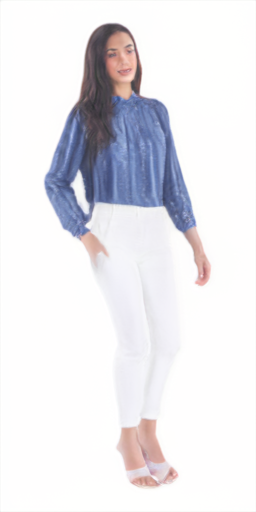

In [219]:
with torch.no_grad():
    c = model.stylegan_G(tgt_w)[0]
to_PIL(c).resize((128*2, 256*2))

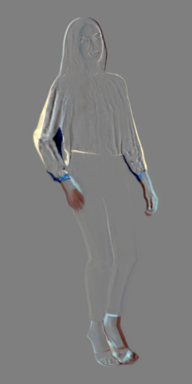

In [220]:
to_PIL(a-c).resize((64*3, 128*3))

In [185]:
from dicomogan.losses.clip_loss import CLIPLoss
clip_loss = CLIPLoss().cuda()

In [186]:
a.shape

torch.Size([3, 1024, 512])

In [194]:
clip_loss.consistency_loss(torch.stack((a, b)).unsqueeze(0).cuda())

tensor(0.0353, device='cuda:0')

In [195]:
clip_loss.consistency_loss(torch.stack((c, b)).unsqueeze(0).cuda())

tensor(0.0291, device='cuda:0')

In [66]:
# style, content, dynamic
n = 4

In [67]:
# for n in range(4):
#     model.style_mapper.medium_mapping.mapper.modulation_module_list[n].combine_modulation_r3.blending_beta.requires_grad = False
#     model.style_mapper.medium_mapping.mapper.modulation_module_list[n].combine_modulation_r3.blending_gamma.requires_grad = False
#     model.style_mapper.medium_mapping.mapper.modulation_module_list[n].combine_modulation_r3.blending_beta[-1] = 0.9
#     model.style_mapper.medium_mapping.mapper.modulation_module_list[n].combine_modulation_r3.blending_gamma[-1] = 0.9

In [68]:
model.style_mapper.fine_mapping.mapper.modulation_module_list[n].combine_modulation.blending_gamma

Parameter containing:
tensor([[[0.0225],
         [0.0288],
         [0.0244],
         [0.0154],
         [0.0148],
         [0.0001],
         [0.0359],
         [0.0398],
         [0.0162],
         [0.0342]]], device='cuda:0', requires_grad=True)

In [69]:
model.style_mapper.fine_mapping.mapper.modulation_module_list[n].combine_modulation.blending_beta

Parameter containing:
tensor([[[0.0160],
         [0.0210],
         [0.0332],
         [0.0248],
         [0.0161],
         [0.0329],
         [0.0262],
         [0.0344],
         [0.0185],
         [0.0317]]], device='cuda:0', requires_grad=True)

In [56]:
model.style_mapper.medium_mapping.mapper.modulation_module_list[n].combine_modulation_12.blending_gamma

Parameter containing:
tensor([[[0.0175],
         [0.0144],
         [0.0204],
         [0.0148]]], device='cuda:0', requires_grad=True)

In [57]:
model.style_mapper.medium_mapping.mapper.modulation_module_list[n].combine_modulation_12.blending_beta

Parameter containing:
tensor([[[0.0127],
         [0.0134],
         [0.0211],
         [0.0181]]], device='cuda:0', requires_grad=True)

In [58]:
model.style_mapper.medium_mapping.mapper.modulation_module_list[n].combine_modulation_r3.blending_gamma

Parameter containing:
tensor([[[-0.0284],
         [-0.0222],
         [-0.0048],
         [ 0.0139]]], device='cuda:0', requires_grad=True)

In [59]:
model.style_mapper.medium_mapping.mapper.modulation_module_list[n].combine_modulation_r3.blending_beta

Parameter containing:
tensor([[[-0.0293],
         [-0.0220],
         [-0.0034],
         [ 0.0141]]], device='cuda:0', requires_grad=True)

In [80]:
model.style_mapper.fine_mapping.mapper.modulation_module_list[n].combine_modulation.blending_gamma

Parameter containing:
tensor([0.0930], device='cuda:0', requires_grad=True)

In [81]:
model.style_mapper.fine_mapping.mapper.modulation_module_list[n].combine_modulation.blending_beta

Parameter containing:
tensor([0.1266], device='cuda:0', requires_grad=True)

# Generate images for eval 

In [60]:
with open('data/fashion/fashion_train_videos.txt', 'r') as f:
    train_videos = f.read().split('\n')

In [61]:
with open('data/fashion/fashion_test_videos.txt', 'r') as f:
     test_videos = f.read().split('\n')

In [133]:
from tqdm import tqdm
def generate(lst, save_dir, desc, bs=4):
    with torch.no_grad():
        for i in tqdm(range(0, len(lst), bs)):
            images, inversions = [], [],
            for j in range(i, i+bs):
                a, b, c, _ = load_video(lst[j])
                images.append(a)
                inversions.append(b)
                sampleT = c
            
#             print(torch.stack(images, 0).shape, torch.stack(inversions, 0).shape)
            edited_videos = forward_triple(model, torch.stack(images, 0), torch.stack(inversions, 0), sampleT, [desc] * bs)          
            for video, video_name in zip(edited_videos, lst[i:i+bs]):
                save_path = os.path.join(save_dir, video_name)
                os.makedirs(save_path, exist_ok=True)
                for j, frame in enumerate(video):
                    to_PIL(frame).save(os.path.join(save_path, f"{j:06d}.png"))

In [134]:
train_save_dir = os.path.join("model_outputs", f"{model_dir.split('/')[-1]}", "train")

In [139]:
test_save_dir = os.path.join("model_outputs", f"{model_dir.split('/')[-1]}", "test")

In [136]:
desc = "A picture of a woman wearing a Women's Black Regular fit Blouse with a Round neckline and Long sleeves and a blue jean"

In [137]:
train_videos = np.array(train_videos)

In [140]:
generate(test_videos[:200], test_save_dir, desc)

100%|██████████| 50/50 [20:35<00:00, 24.72s/it]


In [96]:
Image.open('/kuacc/users/abond19/datasets/aligned_fashion_dataset/7c90376/00010.png').size

(512, 1024)